# 파이썬 - 머신러닝 찍먹해보기

탐색적 자료 분석 \

=> 써먹을만한 변수 찾기!!!

## 참고) 코랩 나눔폰트 설치
- 설치후 런타임 재시작 필수!!!!!

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

### 테스트

In [ ]:
import matplotlib.pyplot as plt
plt.rc("font", family="NanumGothic") # 라이브러리 불러오기와 함께 한번만 실행

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

In [136]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

[케글자료-자전거 수요 예측](https://www.kaggle.com/competitions/bike-sharing-demand/data)

In [138]:
DATA_PATH = '/content/drive/MyDrive/Multicampus28/Data/'
train = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')
submission = pd.read_csv(DATA_PATH + 'sampleSubmission.csv')

In [139]:
train.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16


In [140]:
test.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027


In [141]:
submission.head(1)

,datetime,count
0,2011-01-20 00:00:00,0


## 탐색적 자료 분석

- datetime
  - 1시간 간격 데이터 수집

- season
  - 1. 봄/ 2. 여름/ 3. 가을/ 4. 겨울

- holiday
  - 0. 공휴일 아님 / 1. 공휴일

- workingday
  - 0. 평일 아님/ 1. 평일

- weather
  - 1. 맑음/ 2. 약간흐림/ 3. 약한 눈/ 4. 기상최악

- 종속변수 : count(자전거 대여 수량)

## 문제 정의

- 각 시간대 별로 자전거 대여 수량을 예측하세요

### 데이터 확인

- casual, registered 가 훈련데이터에 존재, 테스트 데이터에는 없는 상황

  - casual : 비회원수
  - registered : 회원수

### 피처 수정 - 날짜 데이터 가공

In [142]:
train['datetime']

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
10881    2012-12-19 19:00:00
10882    2012-12-19 20:00:00
10883    2012-12-19 21:00:00
10884    2012-12-19 22:00:00
10885    2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: object

오브젝트로 저장되어있음.

In [143]:
# 편한 방법
# train['DT'] = pd.to_datetime(train['datetime'])

# 정석
train['Date'] = train['datetime'].apply(lambda x: x.split()[0]) #날짜피처 생성
train['Year'] = train['Date'].apply(lambda x: x.split('-')[0])
train['Month'] = train['Date'].apply(lambda x : x.split('-')[1])
train['Day'] = train['Date'].apply(lambda x : x.split('-')[2])
train['Hour'] = train['datetime'].apply(lambda x : x.split()[1].split(':')[0])
train['Minute'] = train['datetime'].apply(lambda x : x.split()[1].split(':')[1])
train['Second'] = train['datetime'].apply(lambda x : x.split()[1].split(':')[2])

train.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,Date,Year,Month,Day,Hour,Minute,Second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00


이제 요일 반환해야함

In [144]:
from datetime import datetime
import calendar

samp_dt = train['Date'][300]  # 1월 13일 - 오브젝트 타입
print(datetime.strptime(samp_dt, "%Y-%m-%d"))  # datetime TYPE 변경함
print(datetime.strptime(samp_dt, "%Y-%m-%d").weekday())  # 요일이 정수로 반환됨
print(calendar.day_name[3]) # 요일 이름 반환

# 위 4줄 활용, train 데이터의 Date 열 요일이름 만들기
train['Weekday'] = train['Date'].apply(lambda x : calendar.day_name[datetime.strptime(x, "%Y-%m-%d").weekday()])
train.head(1)

2011-01-13 00:00:00
3
Thursday


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,Date,Year,Month,Day,Hour,Minute,Second,Weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday


In [145]:
# season
train['season'] = train['season'].map({1:"Spring", 2:"Summer", 3:"Fall", 4:"Winter"})

# weather
train['weather'] = train['weather'].map({1:"Clear", 2:"NotBad", 3:"Bad", 4:"worst"})

train.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,Date,Year,Month,Day,Hour,Minute,Second,Weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday


In [150]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  object 
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  object 
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
 12  Date        10886 non-null  object 
 13  Year        10886 non-null  object 
 14  Month       10886 non-null  object 
 15  Day         10886 non-null  object 
 16  Hour        10886 non-null  object 
 17  Minute      10886 non-null  object 
 18  Second      10886 non-null  object 
 19  Weekday     10886 non-nul

## 시각화 코드 작성

- count = x1 + x2 + ~~

- 종속변수(=반응변수) 가 제일 중요한 변수

- 시각화를 진행시 체크사항
  - count(목적) 고정값 => 수치데이터

  - 수치데이터를 기반으로 한 시각화의 종류는?
    - 히스토그램 : count
    - 산점도 : count, 수치형변수 중 하나
    - 히트맵 : count, 수치형변수 중 하나
    - 막대그래프, 박스플롯, 선.. : count, 범주형 변수 중 하나

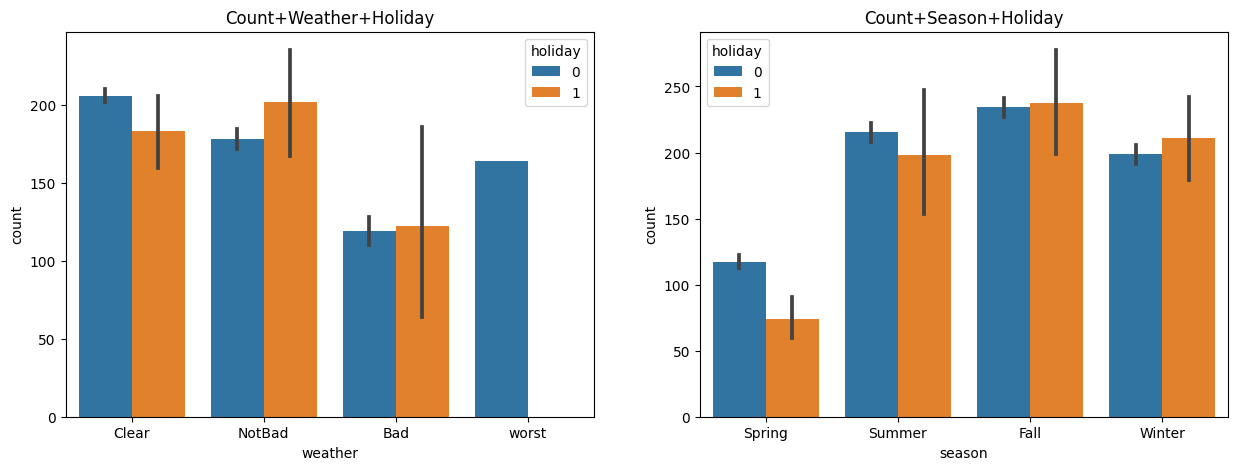

In [154]:
# 시각화
fig, ax = plt.subplots(1, 2, figsize= (15, 5))
# plt.show()

# 산점도
# sns.scatterplot(data = train, x='Date', y='count', ax = ax[0])

# 바 그래프
sns.barplot(x="weather", y="count", data= train,hue='holiday', ax=ax[0])
sns.barplot(x="season", y="count", data= train, hue='holiday', ax=ax[1])

#


# 히스토그램
# plt.hist(train['count'], histtype='bar', axes = axes[1,1])
# plt.title('Histplot')

ax[0].set_title('Count+Weather+Holiday')
ax[1].set_title('Count+Season+Holiday')

plt.show()

# 탐색적 데이터 분석
코드 한 줄 한 줄 의미가있어야함(목적에맞게)
- **키워드**: *Feature Engineering*(피쳐엔지니어링) ==> 머신러닝 알고리즘에 적용할 독립변수를 찾아서 넣어주는 것

탐색적 데이터 분석 : 독립변수를 추리는 것

---
- 머신러닝 진행할 때 왜 하냐?
  - 머신러닝?: 예측을 하기 위한 방법론
    - 최신 알고리즘이 있으니까 그거 쓰면 다 되는거 아님?
    - 오차가 가장 적은 결과를 찾는것!
    - 머신러닝의 핵심은 필요한 변수(컬럼)를 찾는것!

<br>

- 시각화를 작성해서 얻고자 하는 목적
  - 필요한 컬럼과 필요없는 컬럼을 찾는 것
    - ex.절대온도와 상대온도 컬럼중 더 필요한건?

---

 **머신러닝**: 각 독립변수의 기울기를 찾는 것: 정형 데이터 컬럼 존재 + 전처리 => 인간이 하는 것

**딥러닝** : 비정형 데이터(이미지, 동영상) => 알고리즘이 하는 것

---

단, 변수 선정시 논리적인 이유가 함께 있어야함


## 시각화로 예시보기

In [155]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

### 종속변수 로그변환

<Axes: xlabel='count', ylabel='Count'>

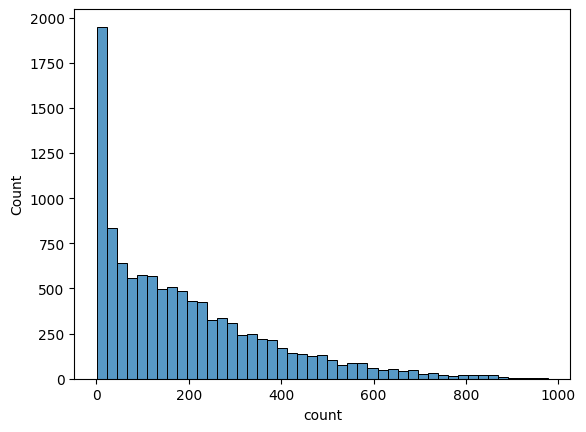

In [157]:
# matplotlib 시각화 하면 이거는 꼭하자
fig, ax = plt.subplots()

# 시각화 - 분포표
sns.histplot(train['count'])

<Axes: xlabel='count', ylabel='Count'>

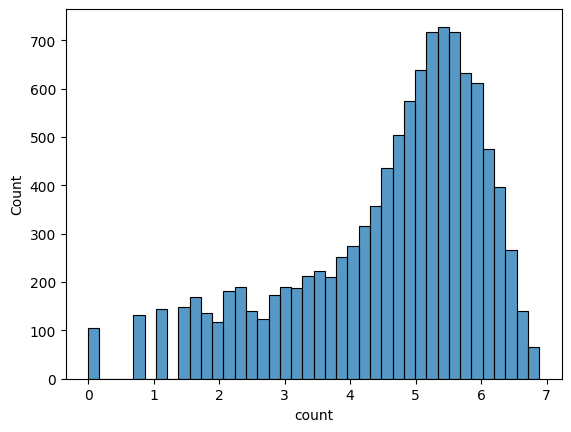

In [158]:
# 그래프가 정규분포 모양이 아님 ->
# 로그변환 등으로 정규분포모양으로 바꿔야됨 ->
# 굳이할필욘없지만(알고리즘에 따라 다름) 해볼거임

sns.histplot(np.log(train['count']))

### 정규분포 모양새로 바꿔줌
=> 종속변수는 로그변환을 취해서 학습을 진행 하기로 한다. \
=> 로그변환을 하면, 예측 시 로그변환 된 값을 예측하게됨\
=> 로그변환된 값을 지수변환으로 변경해서 최종 예측을 진행함

<br>

### 순서
1. 정규분포화(로그변환)
2. 예측
3. 지수변환

### 막대 그래프 그리기

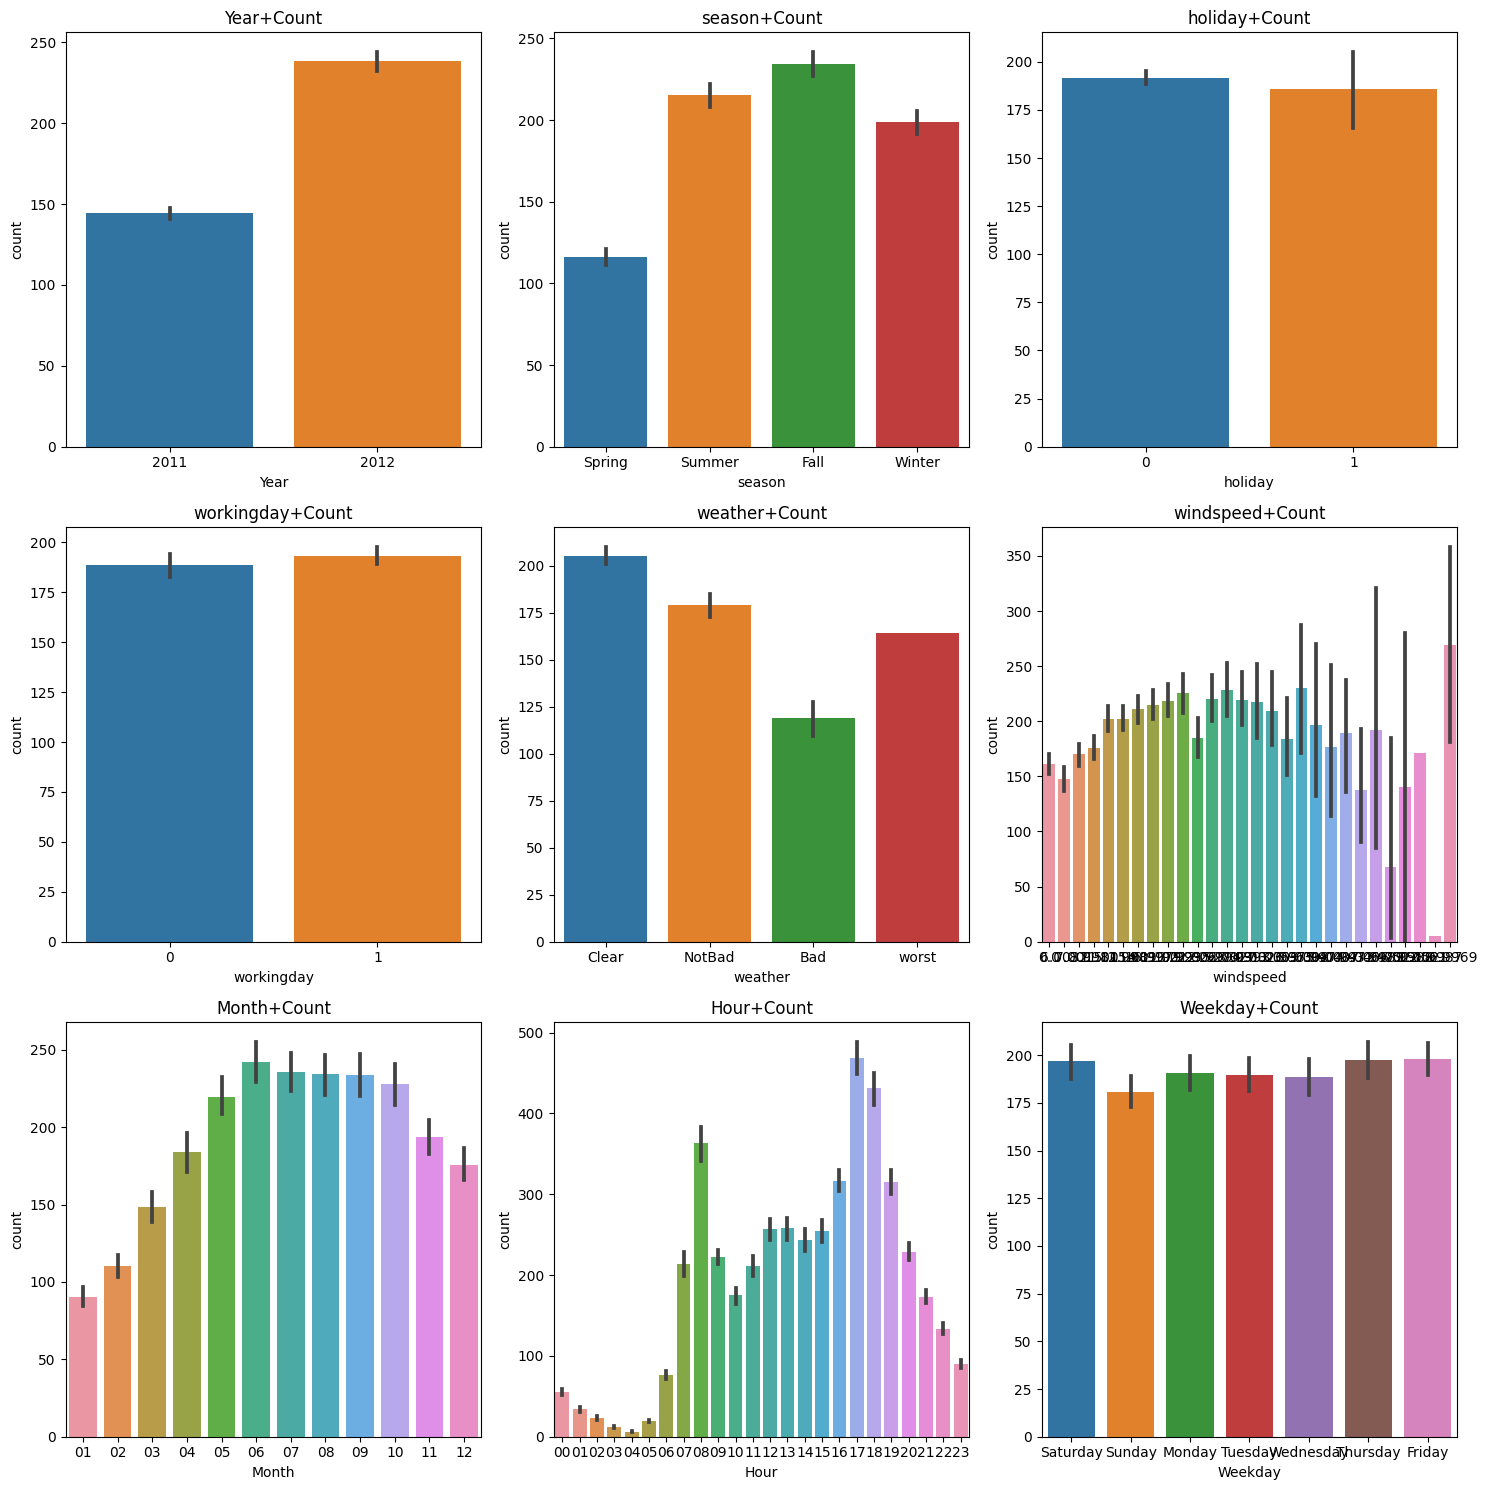

In [175]:
fig, ax = plt.subplots(3,3, figsize=(15,15))

# datetime	season	holiday	workingday	weather	temp	atemp	humidity	windspeed	casual	registered	count	Date	Year	Month	Day	Hour	Minute	Second	Weekday

sns.barplot(x = 'Year', y = 'count', data = train, ax=ax[0,0])
ax[0,0].set_title("Year+Count")

sns.barplot(x = 'season', y = 'count', data = train, ax=ax[0,1])
ax[0,1].set_title("season+Count")

sns.barplot(x = 'holiday', y = 'count', data = train, ax=ax[0,2])
ax[0,2].set_title("holiday+Count")

sns.barplot(x = 'workingday', y = 'count', data = train, ax=ax[1,0])
ax[1,0].set_title("workingday+Count")

sns.barplot(x = 'weather', y = 'count', data = train, ax=ax[1,1])
ax[1,1].set_title("weather+Count")

sns.barplot(x = 'windspeed', y = 'count', data = train, ax=ax[1,2])
ax[1,2].set_title("windspeed+Count")

sns.barplot(x = 'Month', y = 'count', data = train, ax=ax[2,0])
ax[2,0].set_title("Month+Count")

sns.barplot(x = 'Hour', y = 'count', data = train, ax=ax[2,1])
ax[2,1].set_title("Hour+Count")

sns.barplot(x = 'Weekday', y = 'count', data = train, ax=ax[2,2])
ax[2,2].set_title("Weekday+Count")

plt.tight_layout()
plt.show()

### Task 01 = 칼럼 비교
막대 그래프를 컬럼마다 그렸다. \
이 중 필요없는 컬럼을 찾자

In [176]:
# 테스트 데이터 전처리

test['Date'] = test['datetime'].apply(lambda x: x.split()[0]) #날짜피처 생성
test['Year'] = test['Date'].apply(lambda x: x.split('-')[0])
test['Month'] = test['Date'].apply(lambda x : x.split('-')[1])
test['Day'] = test['Date'].apply(lambda x : x.split('-')[2])
test['Hour'] = test['datetime'].apply(lambda x : x.split()[1].split(':')[0])
test['Minute'] = test['datetime'].apply(lambda x : x.split()[1].split(':')[1])
test['Second'] = test['datetime'].apply(lambda x : x.split()[1].split(':')[2])

test.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Date,Year,Month,Day,Hour,Minute,Second
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011-01-20,2011,01,20,00,00,00


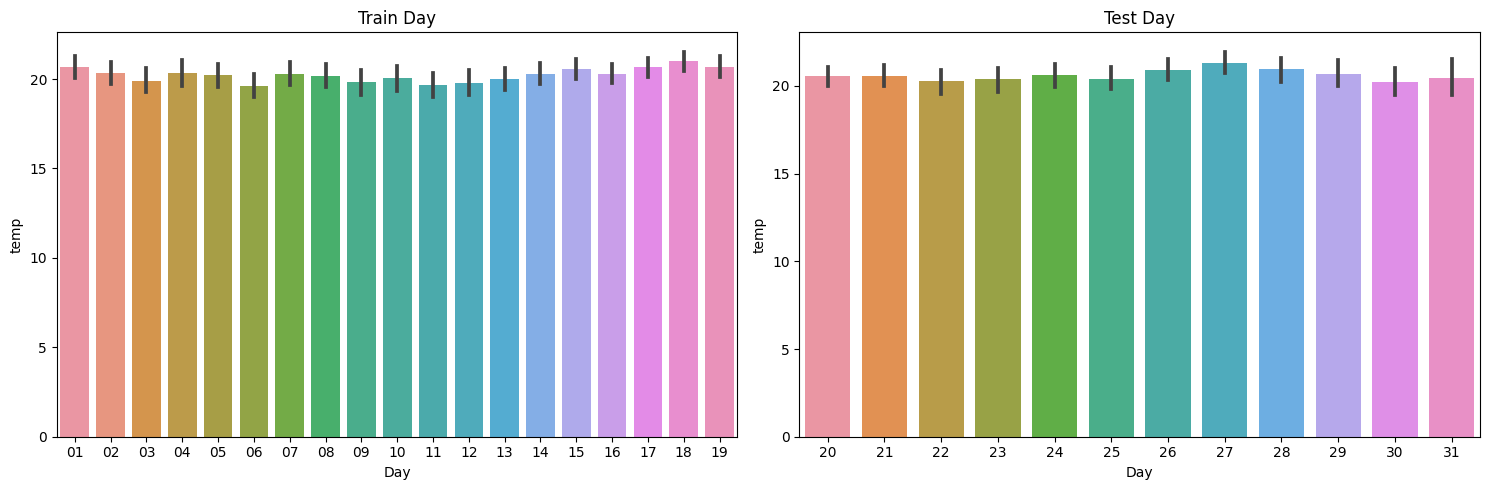

In [179]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

# 트레인과 테스트 데이터 차이

sns.barplot(x = 'Day', y = 'temp', data = train, ax=ax[0])
ax[0].set_title("Train Day")

sns.barplot(x = 'Day', y = 'temp', data = test, ax=ax[1])
ax[1].set_title("Test Day")

plt.tight_layout()
plt.show()

### Task02 = Day 칼럼 비교
두 데이터 비교 결론

트레인은 1-19일\
테스트는 20-31일

즉, Day 컬럼은 분석에 필요가 없다.
  - 참조할만한 데이터(날짜)가 없음

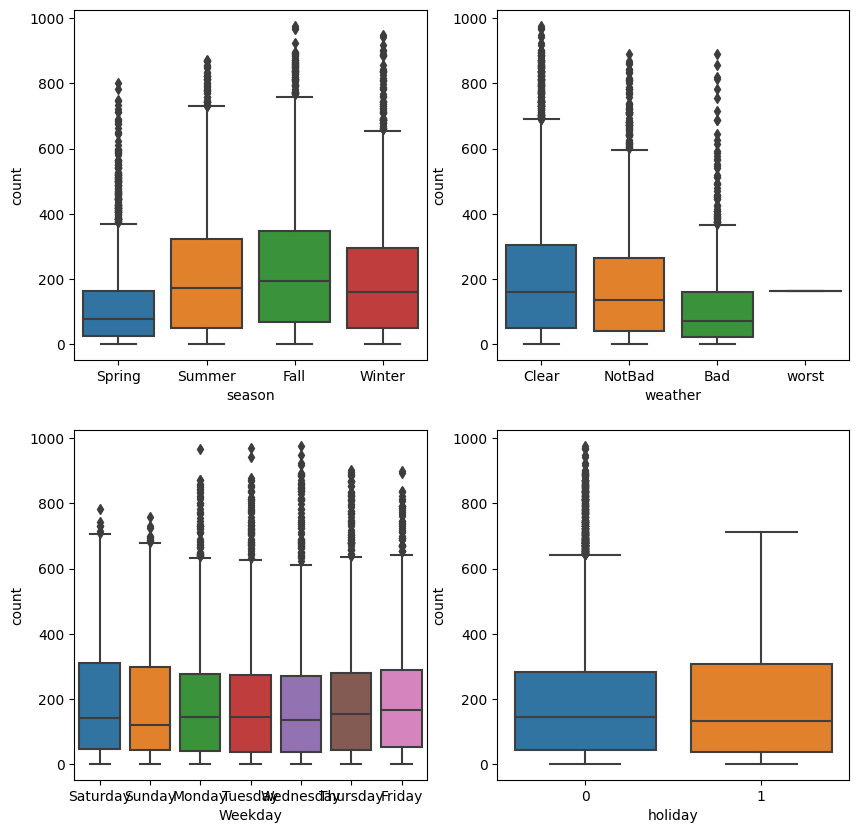

In [189]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

# boxplot 그리기

sns.boxplot(x='season', y='count', data = train, ax=ax[0,0])
sns.boxplot(x='weather', y='count', data = train, ax=ax[0,1])
sns.boxplot(x='Weekday', y='count', data = train, ax=ax[1,0])
sns.boxplot(x='holiday', y='count', data = train, ax=ax[1,1])

plt.show()

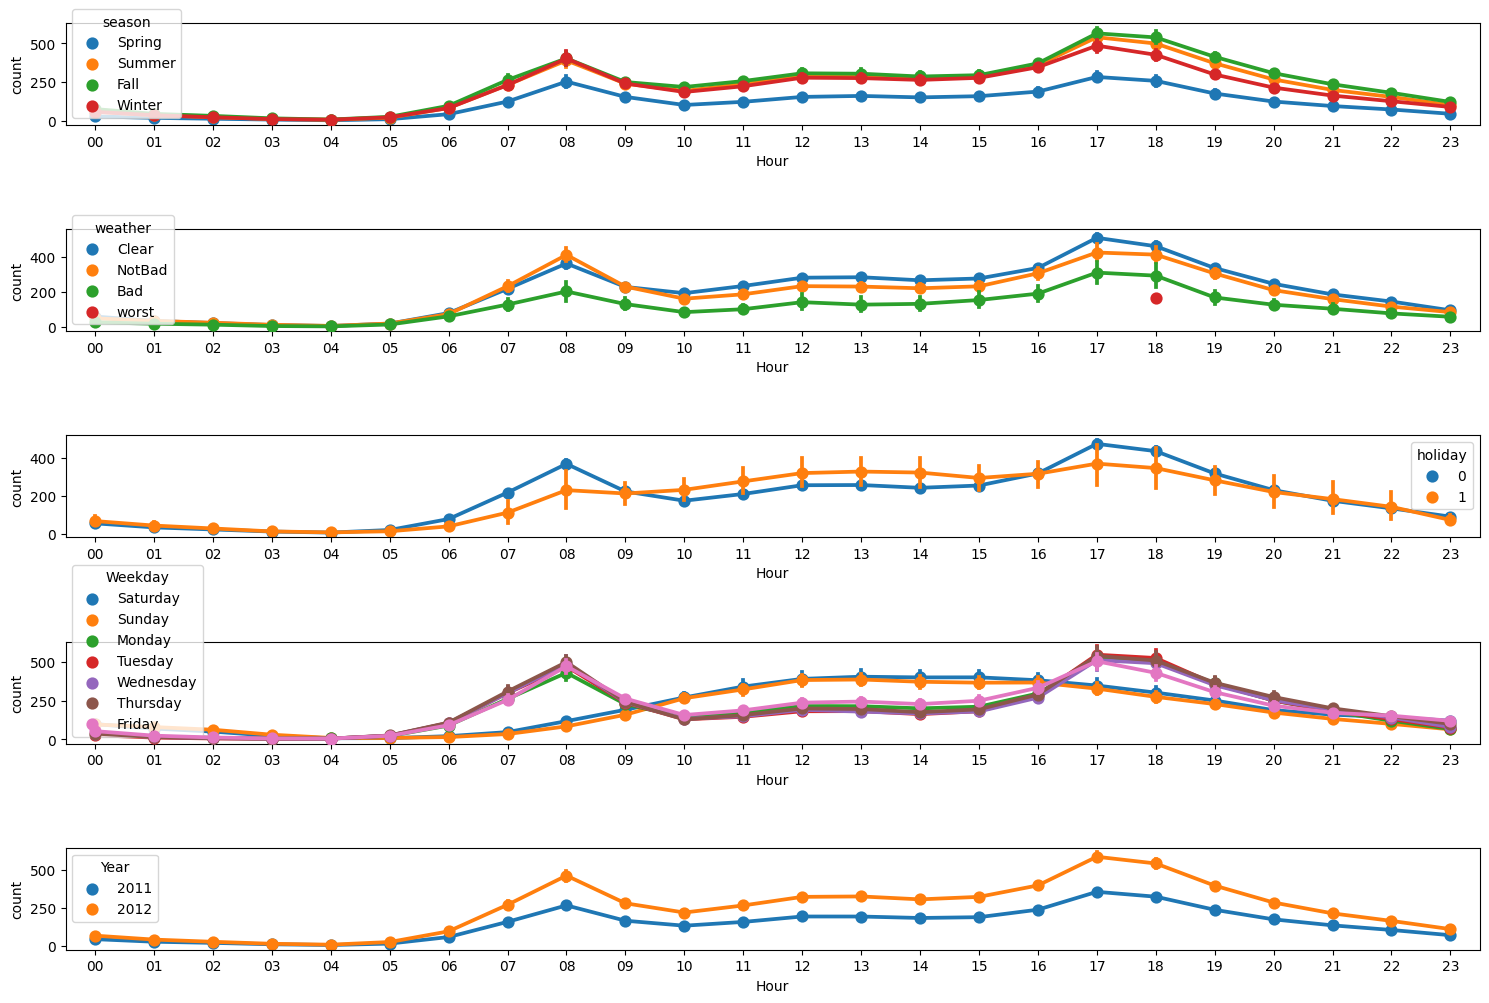

In [202]:
# v포인트 그래프
fig, ax = plt.subplots(nrows= 5, figsize = (15, 10))

sns.pointplot(x= 'Hour', y='count', hue='season', data=train, ax=ax[0])
sns.pointplot(x='Hour', y='count',hue= 'weather', data=train, ax=ax[1])
sns.pointplot(x='Hour', y='count',hue= 'holiday', data=train, ax=ax[2])
sns.pointplot(x='Hour', y='count',hue= 'Weekday', data=train, ax=ax[3])
sns.pointplot(x='Hour', y='count',hue= 'Year', data=train, ax=ax[4])

plt.tight_layout()
plt.show()

In [203]:
train['weather'].value_counts()

Clear     7192
NotBad    2834
Bad        859
worst        1
Name: weather, dtype: int64

### Task03 = 시각화로 이상치 확인함!
- 날씨 중 안좋은 날에 200이나 빌렸다!
  - 확인할 것
      - 시스템 이상인가?
      - 정말 날씨가 이상했나? => 기상청 확인

  - 처리
    - 개발자(PM)에게 알린다 => 개발 과정의 문제를 확인
    - 판단하기 => 이상치 제거?/대체?

### 회귀식과 산점도

- regplot() 사용

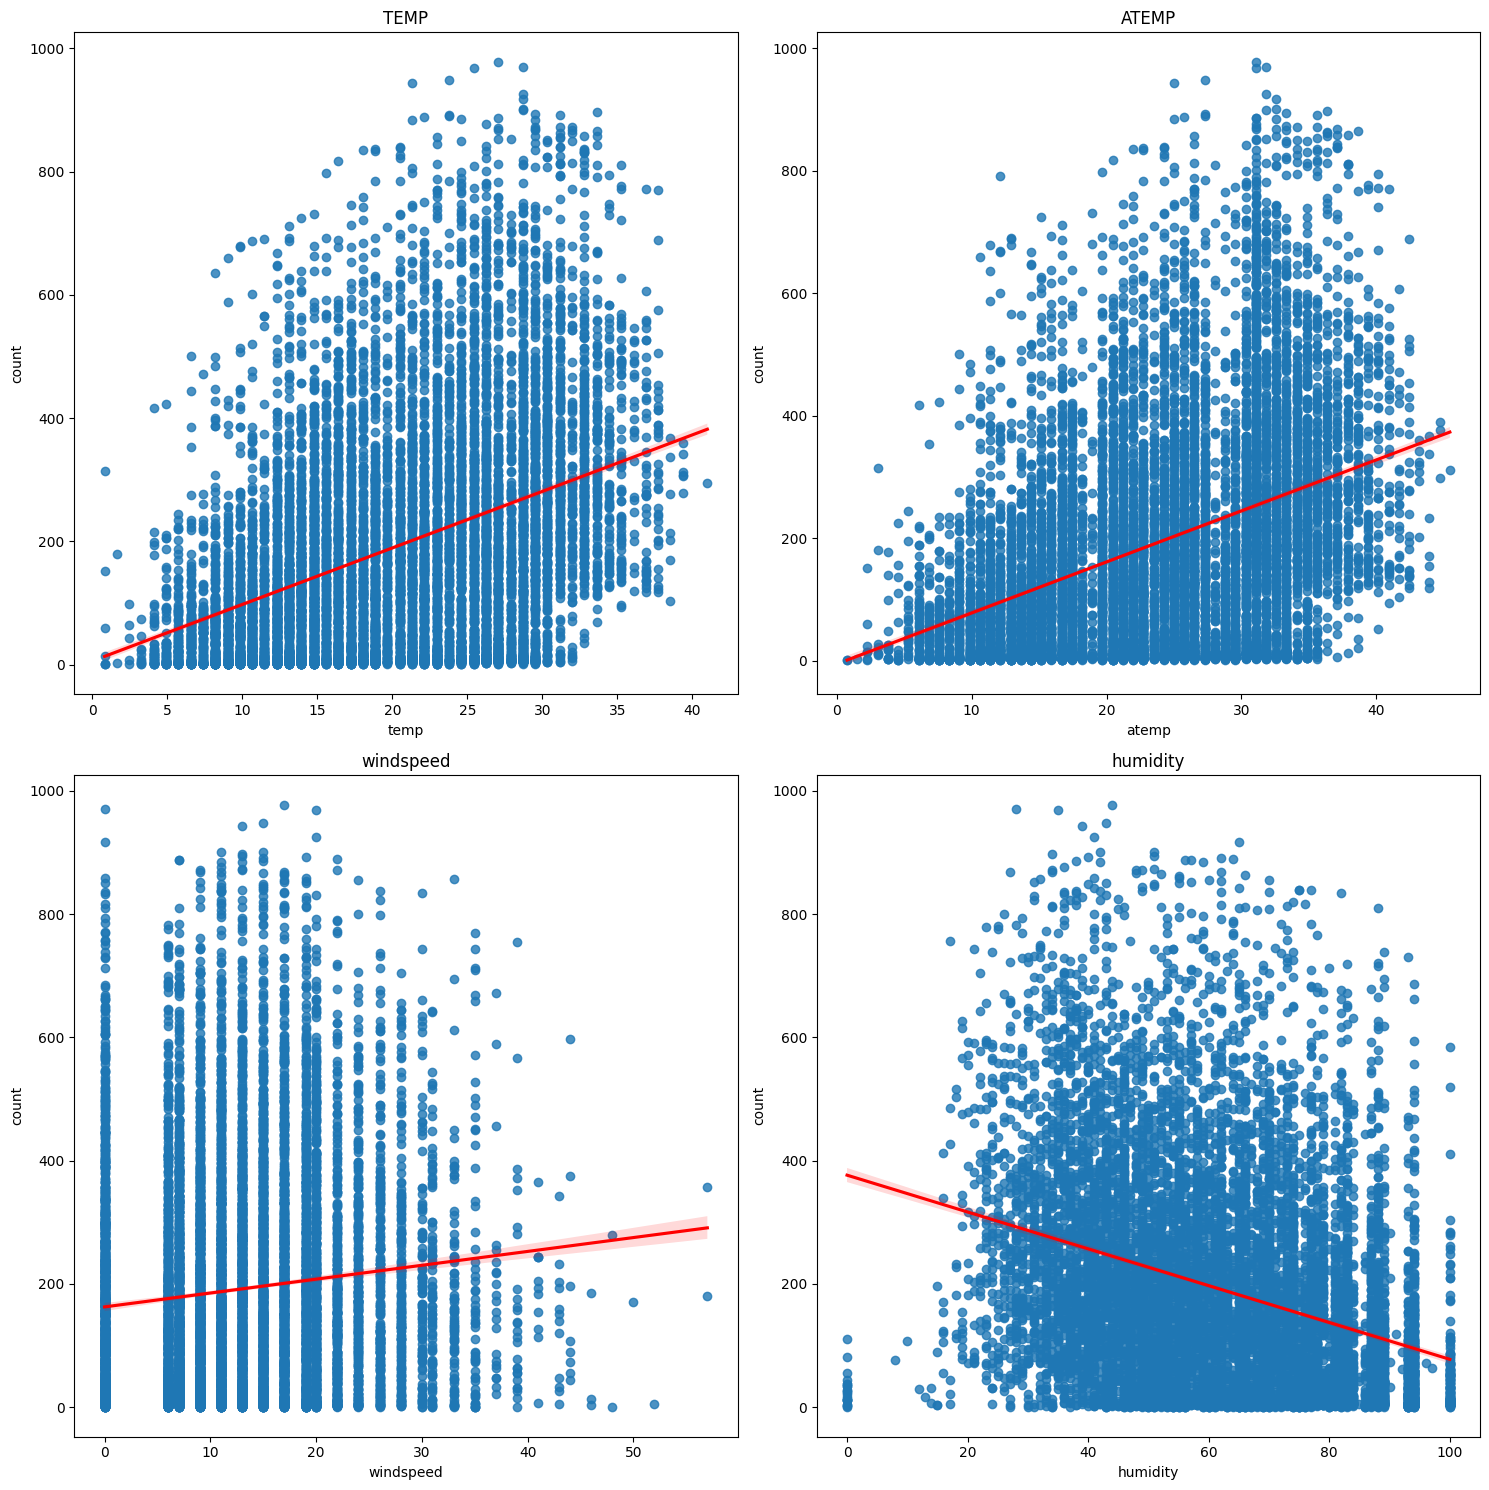

In [215]:
fig, ax = plt.subplots(2,2 , figsize=(15, 15))

sns.regplot(x='temp', y='count', data = train, ax=ax[0,0], line_kws={'color':'red'})
ax[0,0].set_title("TEMP")

sns.regplot(x='atemp', y='count', data = train, ax=ax[0,1], line_kws={'color':'red'})
ax[0,1].set_title("ATEMP")

sns.regplot(x='windspeed', y='count', data = train, ax=ax[1,0], line_kws={'color':'red'})
ax[1,0].set_title("windspeed")

sns.regplot(x='humidity', y='count', data = train, ax=ax[1,1], line_kws={'color':'red'})
ax[1,1].set_title("humidity")

plt.tight_layout()
plt.show()

변수 선택 \
기울기가 크고 좋은 변수를 고른다.

- 절대온도 \
기울기 좋고 자료 분포 좋고

- 상대온도 \
기울기 좋고 자료 분포 좋고

- 바람속도 \
바람속도는 0인 값이 너무 많다\
=> 어떻게 처리함? \
=> 할게 많아지네 => 기각

- 습도 \
우하향이네? \
=> 기울기 좋고 분포 좋네

## 최종적인 input 변수 선정

=> 탐색적 데이터 분석 끝!

In [ ]:
cols = ['count', '~~', '~~']

final_df = train.loc[['weather'] == "worst", cols]

# 이 다음 할 것 - 모델링

근데 모델링 평가지표가 낮게(0.8~이하정도) 나온다?\
=> 다시 탐색적 데이터 분석하기!

**평가 지표가 0.9 이상이 나오도록!**

즉,
`탐색 > 모델링 > 평가`
무한반복